In [1]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import csv
import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
dataset_path = "../input/gtzan-dataset-music-genre-classification/Data/genres_original"
json_path = "output.json"

In [3]:
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

n_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 5

# Audio File Processing

In [4]:
def extract_mfcc_from_segment(signal, start_sample, finish_sample, n_mfcc, n_fft, hop_length):
    """Extract MFCC features from a segment of the audio signal."""
    segment_signal = signal[start_sample:finish_sample]
    mfcc_features = librosa.feature.mfcc(y=segment_signal, sr=SAMPLE_RATE, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
    return mfcc_features.T  

def process_genre(genre_name, dirpath, filenames, data, expected_vects_ps, samples_ps, num_segments, genre_list, pbar):
    """Process audio files for a single genre and append MFCC features to data."""
    for f in filenames:
        if f == "jazz.00054.wav":  # Skip the specific file
            continue

        file_path = os.path.join(dirpath, f)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        for s in range(num_segments):
            start_sample = samples_ps * s
            finish_sample = start_sample + samples_ps

            # Extract MFCC for the current segment
            mfcc_features = extract_mfcc_from_segment(signal, start_sample, finish_sample, n_mfcc, n_fft, hop_length)

            if len(mfcc_features) == expected_vects_ps:
                data["mfcc_features"].append(mfcc_features.tolist())
                data["labels"].append(genre_list.index(genre_name))

        
        pbar.update(1)  

def process_files(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Main function to process audio files and extract MFCC."""
    data = {
        "mfcc_features": [],
        "labels": [],
    }

    genre_list = [
        "disco", "metal", "reggae", "blues", "rock", 
        "classical", "jazz", "hiphop", "country", "pop"
    ]

    samples_ps = int(SAMPLES_PER_TRACK / num_segments)  
    expected_vects_ps = math.ceil(samples_ps / hop_length)

    # For tqdm
    total_files = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(dataset_path) if dirpath != dataset_path])

    with tqdm(total=total_files, desc="Processing Audio Files", unit="file") as pbar:
        
        # loop through all the genres
        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
            if dirpath != dataset_path:
                dirpath_comp = dirpath.split("/")
                genre_name = dirpath_comp[-1]
                
            
                if genre_name in genre_list:
                    process_genre(genre_name, dirpath, filenames, data, expected_vects_ps, samples_ps, num_segments, genre_list, pbar)

    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

In [5]:
start_time = time.time()
process_files(dataset_path, json_path)
end_time = time.time()


print(f"Total processing time: {end_time - start_time:.2f} seconds")


Processing Audio Files: 100%|█████████▉| 999/1000 [01:43<00:00,  9.69file/s]


Total processing time: 132.90 seconds


In [6]:
with open(json_path, "r") as f:
    data = json.load(f)

# Extract features and labels
X = np.array(data["mfcc_features"])
y = np.array(data["labels"])


In [7]:
X.shape
y.shape

(4993,)

In [8]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 64% train, 16% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {len(X_train)}")
print(f"Validation data shape: {len(X_val)}")
print(f"Test data shape: {len(X_test)}")

Training data shape: 3195
Validation data shape: 799
Test data shape: 999


In [9]:
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(3195, 259, 13), y_train=(3195,)
Validation data shape: X_val=(799, 259, 13), y_val=(799,)
Test data shape: X_test=(999, 259, 13), y_test=(999,)


# CNN 

## Proposed network architecture: 

**Input**: Mel-frequency cepstral coefficients (MFCCs) with a shape of (batch_size, time_steps, 13).


**Convolutional Layers**: Two convolutional layers that learn spatial patterns in the sequence data.


**Max Pooling**: Reduces the dimensionality of the feature map.


**Flattening**: Converts the 2D feature map into a 1D vector.


**Fully Connected Layer(s)**: Maps the features to a classification output with one output neuron per class (genre).


**Dropout**: Prevents overfitting by randomly dropping connections.

**Output**: Class probabilities for each song genre.

In [ ]:
class GenreClassifier(nn.Module):
    def __init__(self, num_classes):
        super(GenreClassifier, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=13, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # **Calculate output size dynamically**
        with torch.no_grad():
            sample_input = torch.randn(1, 13, 259)  # (batch_size=1, channels=13, time=259)
            sample_output = self._forward_conv(sample_input)
            feature_size = sample_output.shape[1] * sample_output.shape[2]

        self.fc1 = nn.Linear(feature_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def _forward_conv(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        return x

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to (batch, channels, time)
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)

num_classes = len(set(y_train))  # Number of genres
model = GenreClassifier(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 30
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40  

In [10]:
for epoch in range(num_epochs):
    model.train()  #
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)


    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | Val Acc: {val_accuracies[-1]:.2f}%")

Epoch 1/40 | Train Loss: 1.6351 | Val Loss: 1.2359 | Train Acc: 41.00% | Val Acc: 53.19%
Epoch 2/40 | Train Loss: 1.2521 | Val Loss: 1.0634 | Train Acc: 55.46% | Val Acc: 62.45%
Epoch 3/40 | Train Loss: 1.0711 | Val Loss: 1.0539 | Train Acc: 61.91% | Val Acc: 61.95%
Epoch 4/40 | Train Loss: 0.9160 | Val Loss: 0.9850 | Train Acc: 68.20% | Val Acc: 66.33%
Epoch 5/40 | Train Loss: 0.7993 | Val Loss: 1.0167 | Train Acc: 71.99% | Val Acc: 65.58%
Epoch 6/40 | Train Loss: 0.7480 | Val Loss: 0.8704 | Train Acc: 73.55% | Val Acc: 68.09%
Epoch 7/40 | Train Loss: 0.6284 | Val Loss: 0.8486 | Train Acc: 77.56% | Val Acc: 69.59%
Epoch 8/40 | Train Loss: 0.5484 | Val Loss: 0.9122 | Train Acc: 81.16% | Val Acc: 67.71%
Epoch 9/40 | Train Loss: 0.5046 | Val Loss: 0.9240 | Train Acc: 82.41% | Val Acc: 67.83%
Epoch 10/40 | Train Loss: 0.4242 | Val Loss: 0.8358 | Train Acc: 85.41% | Val Acc: 73.84%
Epoch 11/40 | Train Loss: 0.3776 | Val Loss: 0.8624 | Train Acc: 86.85% | Val Acc: 70.09%
Epoch 12/40 | Train

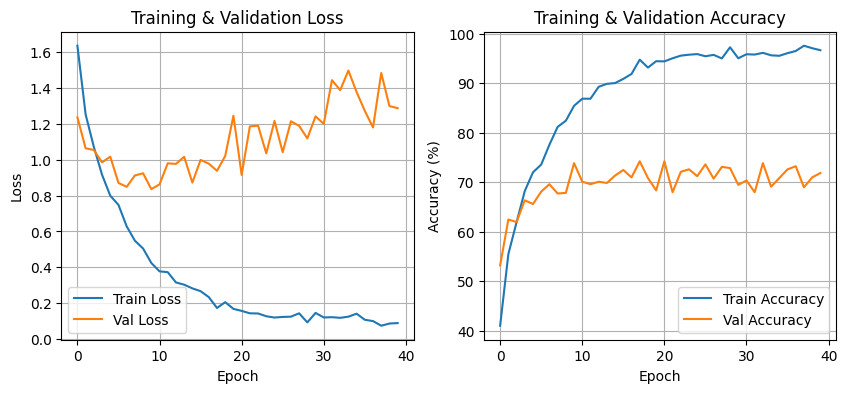

In [11]:

# Loss Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

In [12]:
torch.save(model.state_dict(), 'cnn_model.pth')


# Transformer Based

## **How It Works**
### 1. **Patch Embedding**
- Splits the mel features into small chunks (patches).  
- Converts each patch into a 128-dimensional vector.  
- Adds positional encoding to retain the order of patches.  

### 2. **Transformer Encoder**
- Contains 4 Transformer layers with 8 attention heads.  
- Each layer includes self-attention** and a feedforward network.  
- Dropout (0.2) helps prevent overfitting.  

### 3. **Classification Head**
- Averages the Transformer’s output.  
- Passes it through a small neural network to classify the audio into 10 categories.  

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from einops import rearrange  # For reshaping input

# Model parameters
NUM_CLASSES = 10  
EMBED_DIM = 128  
NUM_HEADS = 8 
DEPTH = 4  
MLP_DIM = 256  
DROPOUT = 0.2 
PATCH_SIZE = 4  

class AudioTransformer(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, depth=DEPTH, mlp_dim=MLP_DIM, patch_size=PATCH_SIZE, dropout=DROPOUT):
        super(AudioTransformer, self).__init__()
        
        self.patch_size = patch_size
        self.patch_embedding = nn.Linear(13 * patch_size, embed_dim)  
        self.positional_encoding = nn.Parameter(torch.randn(1, 259 // patch_size, embed_dim)) 
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        x = rearrange(x, "b t f -> b (t f)") 
        x = x.unfold(dimension=1, size=self.patch_size * 13, step=self.patch_size * 13)  
        x = self.patch_embedding(x) + self.positional_encoding  
        
        x = self.transformer(x)  
        x = x.mean(dim=1)  
        return self.mlp_head(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioTransformer().to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [14]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)


In [15]:
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
            correct += (y_pred.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc = correct / total * 100
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")



Epoch 1/30, Train Loss: 1.6545, Val Loss: 1.3026, Val Acc: 54.94%
Epoch 2/30, Train Loss: 1.2798, Val Loss: 1.1752, Val Acc: 58.32%
Epoch 3/30, Train Loss: 1.1195, Val Loss: 1.0487, Val Acc: 62.08%
Epoch 4/30, Train Loss: 0.9701, Val Loss: 0.9065, Val Acc: 66.96%
Epoch 5/30, Train Loss: 0.8934, Val Loss: 1.0538, Val Acc: 65.46%
Epoch 6/30, Train Loss: 0.8376, Val Loss: 0.9575, Val Acc: 67.96%
Epoch 7/30, Train Loss: 0.7433, Val Loss: 0.9223, Val Acc: 67.21%
Epoch 8/30, Train Loss: 0.6992, Val Loss: 0.7033, Val Acc: 76.72%
Epoch 9/30, Train Loss: 0.6467, Val Loss: 0.7687, Val Acc: 74.84%
Epoch 10/30, Train Loss: 0.6026, Val Loss: 0.7164, Val Acc: 76.85%
Epoch 11/30, Train Loss: 0.5424, Val Loss: 0.7193, Val Acc: 76.97%
Epoch 12/30, Train Loss: 0.4890, Val Loss: 0.6300, Val Acc: 79.72%
Epoch 13/30, Train Loss: 0.5115, Val Loss: 0.7271, Val Acc: 75.09%
Epoch 14/30, Train Loss: 0.5160, Val Loss: 0.6984, Val Acc: 75.84%
Epoch 15/30, Train Loss: 0.4324, Val Loss: 0.6683, Val Acc: 78.47%
Epoc

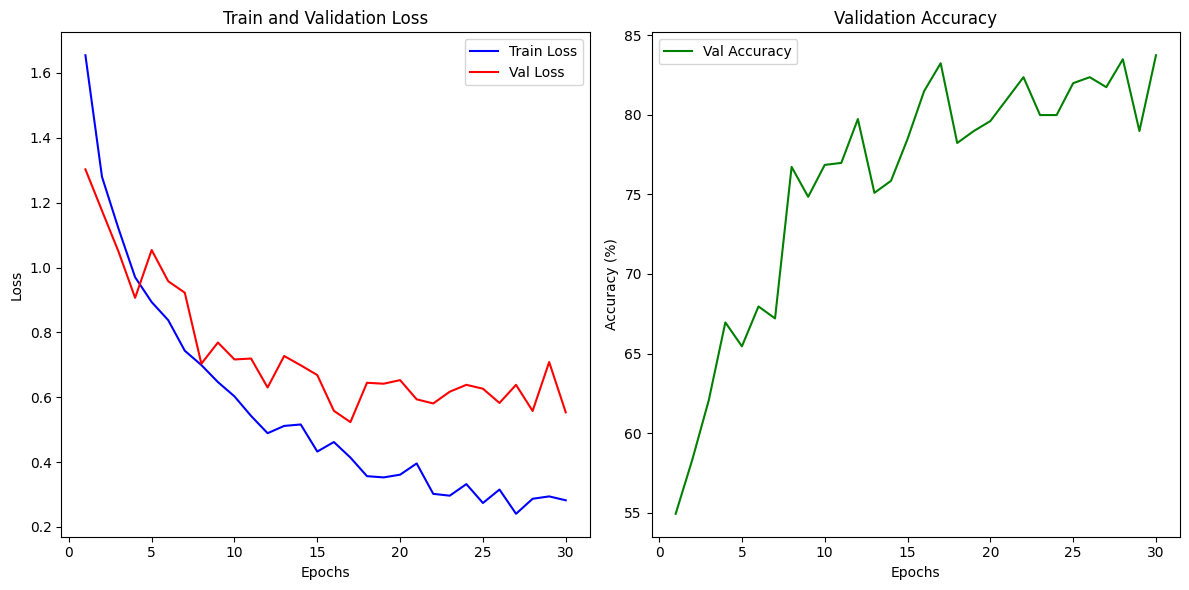

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", color="red")
plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Val Accuracy", color="green")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
torch.save(model.state_dict(), 'audio_transformer_model.pth')
